In [1]:
import torch
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import random
from matplotlib.patches import Rectangle
import tifffile
from torch.utils.data import DataLoader

import importlib as imp
import sys
sys.path.append('/home/abenneck/Desktop/yolo_tiles/docs/scripts')

import yolo_tiles
imp.reload(yolo_tiles)
from yolo_tiles import img_to_tiles, apply_model_to_tiles, load_test_image, preprocess, tileDataset, remove_bbox_in_overlap

import yolo_help
imp.reload(yolo_help)
from yolo_help import bbox_to_rectangles, imshow, convert_data, Net, get_best_bounding_box_per_cell

import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import remove_low_conf_bboxes, postprocess, bb_to_rec

## Load a pretrained model and apply it to a test image

In [3]:
# Load and extract tiles from a simulated image
# img, ncell = load_test_image(500,500)
# padded_img, tiles = img_to_tiles(img)

# Load and extract tiles from a real image
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

# Apply model to tiles + apply bbox edge filtering
outdir_model = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
modelname = 'modelsave.pt'
model_path = os.path.join(outdir_model,modelname)
out_original = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

Finished tiles 100:200/1496 in 6.06s
Finished tiles 400:500/1496 in 25.43s
Finished tiles 500:600/1496 in 10.20s
Finished tiles 600:700/1496 in 10.62s
Finished tiles 700:800/1496 in 9.96s
Finished tiles 800:900/1496 in 10.67s
Finished tiles 900:1000/1496 in 10.41s
Finished tiles 1100:1200/1496 in 18.30s
Finished tiles 1200:1300/1496 in 7.67s
Finished applying model to entire image in 112.34s with 920/1496 (0.6149732620320856:.3f) tiles marked as foreground


### Apply postprocessing + Plot model output

In [7]:
# start0 = time.time()
# net = Net()
# B = net.B
# stride = net.stride
# pads = (np.array(padded_img.shape) - np.array(img.shape))/2
# out_ = postprocess(out, B, stride, pads)
# print(f'Finished postprocessing in {time.time()-start0:.2f}s')

Finished entire image in 102.14s


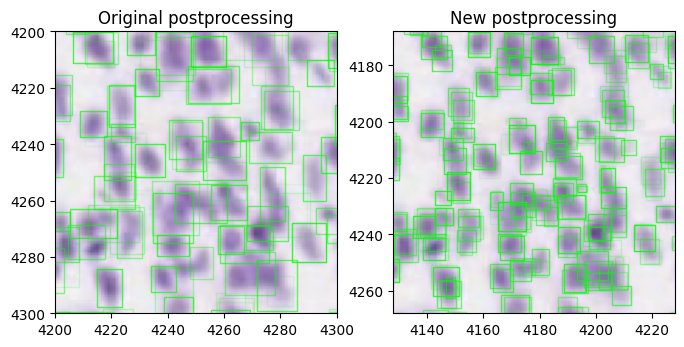

In [6]:
start = time.time()

net = Net()
B = net.B
stride = net.stride

fig, axs = plt.subplots(1,2)

# Display the model results after the OLD workflow
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

axs[0].imshow(padded_img)
bboxes, data = convert_data(out_original[None], B, stride)
scores =  torch.Tensor(data[:,-1])
bboxes, scores = get_best_bounding_box_per_cell(bboxes, scores, B)
predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime',alpha=scores)
axs[0].add_collection(predicted_rectangles)
axs[0].set_title('Original postprocessing')
axs[0].set_xlim([4200,4300])
axs[0].set_ylim([4300,4200])

# Display the model results after the NEW workflow
img_path = '/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg'
out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
out = np.load(out_path)
out = out.transpose((1,2,0))
# axs[1].imshow(padded_img)
pads = (np.array(padded_img.shape) - np.array(img.shape))/2
axs[1].imshow(img)
scores = out[:,:,4].ravel()
predicted_rectangles = bb_to_rec(out, fc='none', ec='lime', alpha=scores)
axs[1].add_collection(predicted_rectangles)
axs[1].set_title('New postprocessing')
axs[1].set_xlim([4200-pads[1], 4300-pads[1]])
axs[1].set_ylim([4300-pads[0], 4200-pads[0]])

fig.set_size_inches((8,4))

print(f'Finished entire image in {time.time()-start:.2f}s')

In [69]:
print(f'Old bb count {len(bboxes)} vs New bb count {len(scores)}')

Old bb count 1181616 vs New bb count 4618656


# Real Data Processing

In [40]:
model_path = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_saved_weights/modelsave_bright_on_dark.pt'
net = Net()
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
# Load a target image
start_total = time.time()
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
# model_path = '/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854/modelsave.pt'
model_path = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_saved_weights/modelsave_bright_on_dark.pt'
next_idx = 666

net = Net()
B = net.B
stride = net.stride

for idx, fname in enumerate(sorted(os.listdir(img_dir))):

    if idx < next_idx:
        continue

    # Load input image
    img_path = os.path.join(img_dir, fname)
    img = tifffile.imread(img_path)

    # img_path = '/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg'
    # img = plt.imread(img_path)
    # img = np.transpose(img, (2,0,1))
    # img = img[0]
    
    # Preprocess using gamma correction + upsampling
    start = time.time()
    img_up = preprocess(img)
    print(f'Finished preprocessing in {time.time()-start:.2f}s')
    
    # Extract tiles from the preprocessed input image
    padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
    
    # Apply model to tiles + apply bbox edge filtering
    print('Applying model to tiles . . .')
    out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

    # Convert the raw model output into a more useful data structure
    print('Postprocessing . . .')
    pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
    out = torch.tensor(out.clone().detach(), dtype=torch.float32)
    out = postprocess(out, B, stride, pads, up_factor=2, verbose=True)

    # Save the processed output
    out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
    # out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
    out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}_instance'
    np.save(out_path, out)
    
    print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
    start_total = time.time()


Finished preprocessing in 2.49s
Finished extracting all tiles in 7.70s
Applying model to tiles . . .
Finished tiles 0:700/5082 in 1.27s
Finished tiles 700:900/5082 in 1.40s
Finished tiles 900:1100/5082 in 1.62s
Finished tiles 1100:1300/5082 in 1.96s
Finished tiles 1300:1400/5082 in 0.77s
Finished tiles 1400:1500/5082 in 1.19s
Finished tiles 1500:1600/5082 in 0.72s
Finished tiles 1600:1700/5082 in 1.22s
Finished tiles 1700:1800/5082 in 0.78s
Finished tiles 1800:1900/5082 in 1.24s
Finished tiles 1900:2000/5082 in 0.85s
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/abenneck/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1032732/966848539.py", line 36, in <module>
    out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)
  File "/home/abenneck/Desktop/yolo_model/yolo_tiles.py", line 330, in apply_model_to_tiles
    out = net((torch.tensor(I[None],dtype=dtype)))
  File "/home/abenneck/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/abenneck/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/abenneck/Desktop/yolo_model/docs/scripts/yolo_help.py", line 246, in forward
  File "/home/abenneck/.local/lib/python3.10/site-packages/torch/nn/

In [2]:
# # Load a target image
# start_total = time.time()
# img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
# model_path = '/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854/modelsave.pt'
# # model_path = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_saved_weights/modelsave_bright_on_dark.pt'
# idx = 500

# net = Net()
# net.load_state_dict(torch.load(model_path))
# net.eval()
# B = net.B
# stride = net.stride

# # Load input image
# fname = sorted(os.listdir(img_dir))[idx]
# img_path = os.path.join(img_dir, fname)
# img = tifffile.imread(img_path)

# # Preprocess using gamma correction + upsampling
# start = time.time()
# img_up = preprocess(img)
# print(f'Finished preprocessing in {time.time()-start:.2f}s')

# # Extract tiles from the preprocessed input image
# padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)



# # # Apply model to tiles + apply bbox edge filtering
# # print('Applying model to tiles . . .')
# # out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

# # # Convert the raw model output into a more useful data structure
# # print('Postprocessing . . .')
# # pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
# # out = torch.tensor(out.clone().detach(), dtype=torch.float32)
# # out = postprocess(out, B, stride, pads, up_factor=2, verbose=True)

# # # Save the processed output
# # out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
# # # out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# # out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}_instance'
# # # np.save(out_path, out)

# # print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
# # start_total = time.time()


Finished preprocessing in 2.53s
Finished extracting all tiles in 6.94s


In [18]:
# img_up = preprocess(img)
# pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
# pads

array([53., 87.])

In [ ]:
# nrow_t = tiles[0]['c_idx']+1
# ncol_t = tiles[0]['r_idx']+1

# # for idx, tile in enumerate(tiles):
# #     p = tile['p']

# #     if (p[0]-pads[0])/2 < 4000 and (p[0]-pads[0])/2 > 3900 and (p[1]-pads[1])/2 < 5100 and (p[1]-pads[1])/2 > 5000:
# #         print(idx)
# #         # break

# idx_start = 2727
# fig, ax = plt.subplots(8,1)
# for idx in range(8):
#     p = tiles[idx_start+idx]['p']
#     ax[idx].imshow(tiles[idx_start + idx]['img'])
#     ax[idx].set_title(f'p: {(p[0]-pads[0])/2}, {(p[1]-pads[1])/2}')

# fig.set_size_inches(4,32)

Finished extracting all tiles in 1.71s
Plotting bboxes . . .
Finished plotting bboxes in 64.54s, 3935136 boxes present
Finished entire image in 64.55s


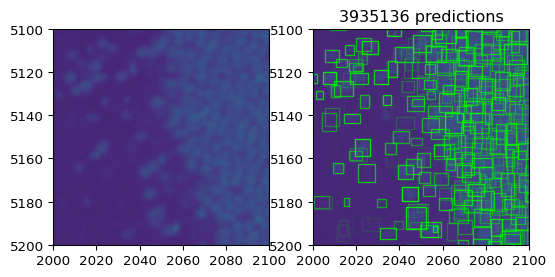

In [10]:
start = time.time()

# TODO: Adjust tiles to original input dimensions for visualization purposes?
addTiles = False
plotBbox = True
setBounds = True

img_idx = 1500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)

img = tifffile.imread(img_path)
img_up = preprocess(img)
if plotBbox:
    padded_img, tiles = img_to_tiles(img, lower_threshold_bg = 0.04, verbose=True)
else:
    padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
tile_dim = tiles[0]['img'].shape[0]

fig, axs = plt.subplots(1,2)

# if plotBbox:
#     for ax in axs:
#         ax.imshow(preprocess(img, upsample=False))
# else:
#     for ax in axs:
#         ax.imshow(padded_img)
for ax in axs:
    ax.imshow(preprocess(img, upsample=False))

out_fname = fname.split('.')[0] + '.npy'
out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
# ec = 'm' if 'home' in out_path else 'lime'
ec = 'lime'
out = torch.Tensor(np.load(out_path))

if addTiles:
    print('Adding tiles . . .')
    start = time.time()
    for tile in tiles:
        p = tile['p']
        bg = tile['bg']
        color = 'k' if bg else 'w'
        for ax in axs:
            rec = Rectangle(p[::-1],tile_dim,tile_dim, facecolor=color, edgecolor='k',alpha = 0.2)
            ax.add_patch(rec)
    print(f'Finished plotting tiles in {time.time()-start:.2f}s, {len(scores)} boxes present')

if plotBbox:
    print('Plotting bboxes . . .')
    # Filter out extra bboxes
    start = time.time()
    scores = out[:,:,-4].ravel()
    predicted_rectangles = bb_to_rec(out,fc='none',ec=ec,alpha=scores)
    axs[1].add_collection(predicted_rectangles)
    axs[1].set_title(f'{len(scores)} predictions')
    print(f'Finished plotting bboxes in {time.time()-start:.2f}s, {len(scores)} boxes present')

if setBounds:
    for ax in axs:
        ax.set_xlim([2000,2100])
        ax.set_ylim([5200,5100])

print(f'Finished entire image in {time.time()-start:.2f}s')

fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

# Batch Mode

### Load + preprocess image, Initialize DataLoader

In [2]:
img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img = tifffile.imread(img_path)
img_up = preprocess(img)
padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04)
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2

nrow_t = int(np.max([tile['r_idx'] for tile in tiles])) + 1
ncol_t = int(np.max([tile['c_idx'] for tile in tiles])) + 1

ds = tileDataset(tiles)
dl = DataLoader(ds, batch_size = ncol_t, shuffle=False)

print(f'{nrow_t} x {ncol_t} tiles')

77 x 66 tiles


### Compare outputs in 'batch mode' and in 'tile mode'

In [3]:
model_path = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
model_path = os.path.join(model_path,'modelsave.pt')
dtype = torch.float32
net = Net()
net.load_state_dict(torch.load(model_path))
net.eval()

B = net.B
stride = net.stride

ds_factor = 8
tile_dim = 256
bbox_dim = 5
num_classes = 3
img_dim0 = padded_img.shape[0]
img_dim1 = padded_img.shape[1]
boundary_cond = (16,16)
ndim = 2

# Apply model to 'nrow_t' several of tiles
start_batch = time.time()
recon_batch = np.zeros((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))
print('Starting batch mode . . .')
for i_batch, batch in enumerate(dl):
    imgs, meta_data = batch
    if np.all(np.array(meta_data['bg'])):
        print(f'Skipping batch {i_batch}/{nrow_t}')
        continue
    else:
        start = time.time()
        out = net(imgs)
        for idx, elem in enumerate(out):
            out_i = remove_bbox_in_overlap(elem[None].clone().detach(), B, stride, tile_dim, boundary_cond = boundary_cond)
            p0 = meta_data['p'][0][idx]
            p1 = meta_data['p'][1][idx]
            recon_batch[:,int(p0/ds_factor):int((p0+tile_dim)/ds_factor), int(p1/ds_factor):int((p1+tile_dim)/ds_factor)] = out_i[0].detach().numpy()
        print(f'Finished batch {i_batch}/{nrow_t} in {time.time()-start:.2f}s')
        start = time.time()

recon_batch = torch.tensor(recon_batch, dtype=torch.float32)
recon_batch = postprocess(recon_batch, B, stride, pads, up_factor=2, verbose=True)
print(f'Finished ALL batches in {time.time()-start_batch:.2f}s\n')


start_tile = time.time()
# Apply model to tiles + apply bbox edge filtering
print('Applying model to tiles . . .')
out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

# Convert the raw model output into a more useful data structure
print('Postprocessing . . .')
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
out = torch.tensor(out.clone().detach(), dtype=torch.float32)
recon_tile = postprocess(out, B, stride, pads, up_factor=2, verbose=True)
print(f'Finished ALL tiles in {time.time()-start_tile:.2f}s\n')

# Save the processed output
# out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
# out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
# np.save(out_path, out)

# print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
start_total = time.time()


Starting batch mode . . .
Skipping batch 0/77
Skipping batch 1/77
Skipping batch 2/77
Skipping batch 3/77
Skipping batch 4/77
Skipping batch 5/77
Skipping batch 6/77
Finished batch 7/77 in 1.74s
Finished batch 8/77 in 2.06s
Finished batch 9/77 in 2.07s
Finished batch 10/77 in 2.20s
Finished batch 11/77 in 2.19s
Finished batch 12/77 in 2.13s
Finished batch 13/77 in 2.08s
Finished batch 14/77 in 2.10s
Finished batch 15/77 in 2.06s
Finished batch 16/77 in 2.12s
Finished batch 17/77 in 2.17s
Finished batch 18/77 in 2.14s
Finished batch 19/77 in 2.14s
Finished batch 20/77 in 2.11s
Finished batch 21/77 in 2.12s
Finished batch 22/77 in 2.10s
Finished batch 23/77 in 2.16s
Finished batch 24/77 in 2.13s
Finished batch 25/77 in 2.16s
Finished batch 26/77 in 2.14s
Finished batch 27/77 in 2.04s
Finished batch 28/77 in 2.14s
Finished batch 29/77 in 2.12s
Finished batch 30/77 in 2.07s
Finished batch 31/77 in 2.19s
Finished batch 32/77 in 2.25s
Finished batch 33/77 in 2.06s
Finished batch 34/77 in 2.1

/tmp/ipykernel_3419949/4064794034.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out.clone().detach(), dtype=torch.float32)


Finished postprocessing in 0.22s
Finished ALL tiles in 21.95s



In [8]:
def tiles_to_orig(tiles, pads):
    tiles_out = []
    for tile in tiles:
        I = tile['img']
        p = tile['p']
        bg = tile['bg']
        r_idx = tile['r_idx']
        c_idx = tile['c_idx']

        # Shift the anchor point by the padded amount on each ax
        p -= pads

        # Reduce anchor point by upsampling factor
        p = np.asarray(p)/2
        
        new_tile = {'img':None, 'p':list(p), 'bg':bg, 'r_idx':r_idx, 'c_idx':c_idx}
        tiles_out.append(new_tile)

    return tiles_out

Adding tiles . . .
Finished plotting tiles in 4.35s, 3935136 boxes present
Plotting bboxes . . .
Finished plotting bboxes0 in 74.71s, 3935136 boxes present
Finished plotting bboxes1 in 151.20s, 3935136 boxes present
Finished entire image in 151.21s


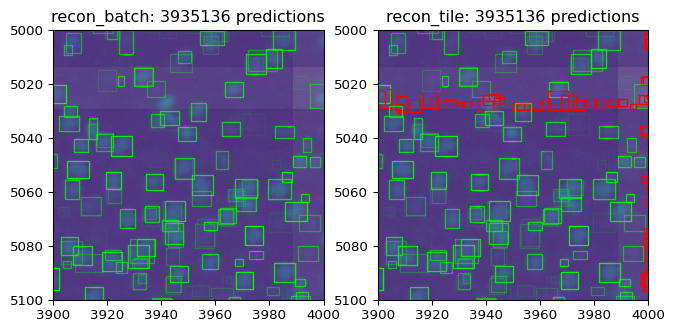

In [21]:
start = time.time()

plotBbox = True
addTiles = True
setBounds = True

img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img_plot = preprocess(img, upsample=False)
tiles_plot = tiles_to_orig(tiles, pads)

fig, ax = plt.subplots(1,2)
for ax_i in ax:
    ax_i.imshow(img_plot)

if addTiles:
    print('Adding tiles . . .')
    start = time.time()
    for tile in tiles_plot:
        p = tile['p']
        bg = tile['bg']
        color = 'k' if bg else 'w'
        rec = Rectangle(p[::-1],tile_dim/2,tile_dim/2, facecolor=color, edgecolor='k',alpha = 0.05)
        ax[0].add_patch(rec)
        rec = Rectangle(p[::-1],tile_dim/2,tile_dim/2, facecolor=color, edgecolor='k',alpha = 0.05)
        ax[1].add_patch(rec)
    print(f'Finished plotting tiles in {time.time()-start:.2f}s, {len(scores)} boxes present')

if plotBbox:
    print('Plotting bboxes . . .')
    start = time.time()
    scores = recon_batch[:,:,-4].ravel()
    predicted_rectangles = bb_to_rec(recon_batch,fc='none',ec='lime',alpha=scores)
    ax[0].add_collection(predicted_rectangles)
    ax[0].set_title(f'recon_batch: {len(scores)} predictions')
    print(f'Finished plotting bboxes0 in {time.time()-start:.2f}s, {len(scores)} boxes present')
    
    start = time.time()
    scores = recon_tile[:,:,-4].ravel()
    ec = ['red' if s==0 else 'lime' for s in scores]
    scores = [1 if s==0 else s for s in scores]
    # ec = 'lime'
    predicted_rectangles = bb_to_rec(recon_tile,fc='none',ec=ec,alpha=scores)
    ax[1].add_collection(predicted_rectangles)
    ax[1].set_title(f'recon_tile: {len(scores)} predictions')
    print(f'Finished plotting bboxes1 in {time.time()-start:.2f}s, {len(scores)} boxes present')

if setBounds:
    for ax_i in ax:
        ax_i.set_xlim([3900,4000])
        ax_i.set_ylim([5100,5000])
        # ax_i.set_xlim([7300,7400])
        # ax_i.set_ylim([8600,8500])

# ax[0].set_xlim([4000,4100])
# ax[0].set_ylim([6200,6100])
# ax[1].set_xlim([4000,4100])
# ax[1].set_ylim([6200,6100])

print(f'Finished entire image in {time.time()-start:.2f}s')

fig.set_size_inches(8,4)
fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

In [24]:
torch.sigmoid(torch.Tensor([-np.inf, -1000, -100, -89, -88]))

tensor([0., 0., 0., 0.])

In [15]:
img_plot.shape

(8587, 7321)

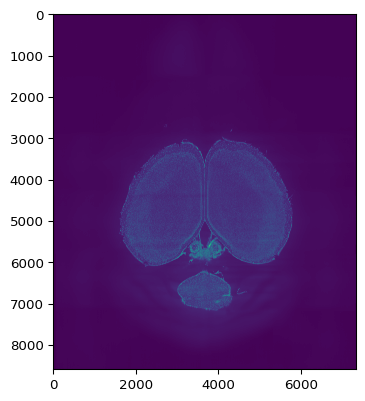

In [11]:
fig,ax = plt.subplots()
ax.imshow(img_plot)